# Tutorial 1. Weakly Supervised Learning
### Technicalities
- TAs -- Evgenii Zheltonozhskii (evgeniizh@campus.technion.ac.il) and Ben Finkelstein (benfin@campus.technion.ac.il)
- Reception hour -- anytime (schedule by e-mail)

### Tutorials
- Similar to 236781 ("Deep Learning")
- Sometimes not entirely self-contained due to complexity of the topics

### HW
- Three HWs, one for each topic

## Convolution Arithmetics Reminder and Transposed Convolutions
Sources:
- https://github.com/vdumoulin/conv_arithmetic
- https://arxiv.org/abs/1603.07285

### Convolution as a linear operation
Lets start from a regular convolution without padding and stride:

![Regular_convolution](conv_arithmetic/gif/no_padding_no_strides.gif)

We can write it as a linear operation over "flatten" input $x \in \mathbb{R}^{16}$:
$$
    W = \begin{pmatrix}
    w_{0,0} & w_{0,1} & w_{0,2} & 0       & w_{1,0} & w_{1,1} & w_{1,2} & 0       &
    w_{2,0} & w_{2,1} & w_{2,2} & 0       & 0       & 0       & 0       & 0       \\
    0       & w_{0,0} & w_{0,1} & w_{0,2} & 0       & w_{1,0} & w_{1,1} & w_{1,2} &
    0       & w_{2,0} & w_{2,1} & w_{2,2} & 0       & 0       & 0       & 0       \\
    0       & 0       & 0       & 0       & w_{0,0} & w_{0,1} & w_{0,2} & 0       &
    w_{1,0} & w_{1,1} & w_{1,2} & 0       & w_{2,0} & w_{2,1} & w_{2,2} & 0       \\
    0       & 0       & 0       & 0       & 0       & w_{0,0} & w_{0,1} & w_{0,2} &
    0       & w_{1,0} & w_{1,1} & w_{1,2} & 0       & w_{2,0} & w_{2,1} & w_{2,2} \\
    \end{pmatrix}
$$
$$y = Wx.$$

The Jacobian of this operation is then
$$\frac{\partial y}{\partial x} = W^\top,$$
which means that a backward pass of the convolution is a transposed convolution. It can be simulated as a regular convolution over padded input:
![Transposed_convolution](conv_arithmetic/gif/no_padding_no_strides_transposed.gif)

We can better see that for 1D input (since for 2D input $W$ is actually 4D tensor which is hard to visualize):
$$W = \begin{pmatrix} w_0 & w_1 & w_2 & 0 \\ 
                      0 & w_0 & w_1 & w_2 
      \end{pmatrix} \\
W^\top = \begin{pmatrix} w_0 & 0   \\ 
                         w_1 & w_0 \\ 
                         w_2 & w_1 \\ 
                         0   & w_2 
      \end{pmatrix}\\
W' = \begin{pmatrix}  w_2& w_1 & w_0 & 0   & 0   & 0   \\ 
                      0  & w_2 & w_1 & w_0 & 0   & 0   \\ 
                      0  & 0   & w_2 & w_1 & w_0 & 0   \\ 
                      0  & 0   & 0   & w_2 & w_1 & w_0
      \end{pmatrix}
$$
Note that $W'$ is a convolution as well (it is circulant), with kernel reversed. Of course, this is very inefficient way to calculate transposed convolution.

Remember that strided convolution is often used for downsampling:

![Regular_convolution_strides](conv_arithmetic/gif/no_padding_strides.gif)

Thus, intuitevely, strided transposed convolution can be used for upsampling:

![Transposed_convolution_strides](conv_arithmetic/gif/no_padding_strides_transposed.gif)

Alternatively, downsampling can be done with dilated convolutions:
![Transposed_convolution](conv_arithmetic/gif/dilation.gif)

## Generic Dense Prediction Model and U-Net

Dense prediction model is usually built of three parts:
- Encoder (can be regular CNN feature extractor, but we'll use not only final features)
- Decoder 
- Prediction heads (segmentation, classification, etc.)

### Example: U-Net

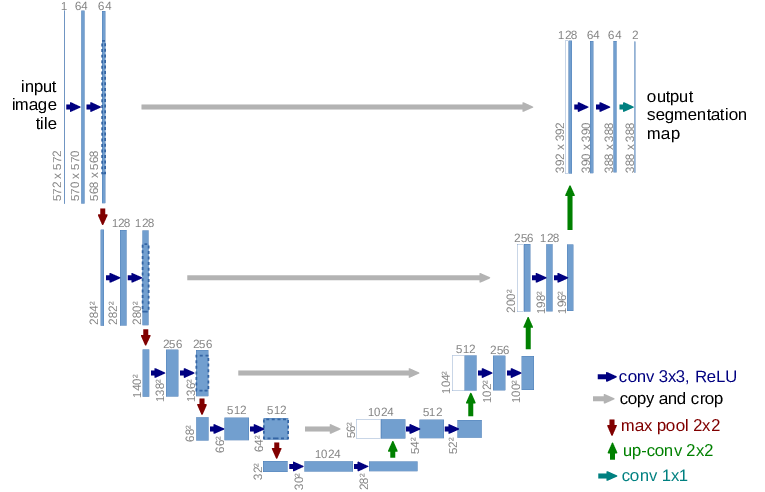

In [1]:
from wand.image import Image as WImage
img = WImage(filename='figures/u-net-illustration-correct-scale2.pdf', resolution=120)
img


In [2]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

In [3]:
import inspect
from IPython.display import Code

from segmentation_models_pytorch.unet.decoder import UnetDecoder, DecoderBlock

In [4]:
Code(inspect.getsource(smp.Unet), language='python')

class Unet(SegmentationModel):
    """Unet_ is a fully convolution neural network for image semantic segmentation. Consist of *encoder* 
    and *decoder* parts connected with *skip connections*. Encoder extract features of different spatial 
    resolution (skip connections) which are used by decoder to define accurate segmentation mask. Use *concatenation*
    for fusing decoder blocks with skip connections.

    Args:
        encoder_name: Name of the classification model that will be used as an encoder (a.k.a backbone)
            to extract features of different spatial resolution
        encoder_depth: A number of stages used in encoder in range [3, 5]. Each stage generate features 
            two times smaller in spatial dimentions than previous one (e.g. for depth 0 we will have features 
            with shapes [(N, C, H, W),], for depth 1 - [(N, C, H, W), (N, C, H // 2, W // 2)] and so on).
            Default is 5
        encoder_weights: One of **None** (random initialization), **"imagenet"** (pre-training on ImageNet) and 
            other pretrained weights (see table with available weights for each encoder_name)
        decoder_channels: List of integers which specify **in_channels** parameter for convolutions used in decoder.
            Lenght of the list should be the same as **encoder_depth**
        decoder_use_batchnorm: If **True**, BatchNorm2d layer between Conv2D and Activation layers
            is used. If **"inplace"** InplaceABN will be used, allows to decrease memory consumption.
            Avaliable options are **True, False, "inplace"**
        decoder_attention_type: Attention module used in decoder of the model. Avaliable options are **None** and **scse**.
            SCSE paper - https://arxiv.org/abs/1808.08127
        in_channels: A number of input channels for the model, default is 3 (RGB images)
        classes: A number of classes for output mask (or you can think as a number of channels of output mask)
        activation: An activation function to apply after the final convolution layer.
            Avaliable options are **"sigmoid"**, **"softmax"**, **"logsoftmax"**, **"identity"**, **callable** and **None**.
            Default is **None**
        aux_params: Dictionary with parameters of the auxiliary output (classification head). Auxiliary output is build 
            on top of encoder if **aux_params** is not **None** (default). Supported params:
                - classes (int): A number of classes
                - pooling (str): One of "max", "avg". Default is "avg"
                - dropout (float): Dropout factor in [0, 1)
                - activation (str): An activation function to apply "sigmoid"/"softmax" (could be **None** to return logits)

    Returns:
        ``torch.nn.Module``: Unet

    .. _Unet:
        https://arxiv.org/abs/1505.04597

    """

    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.decoder = UnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1

In [5]:
Code(inspect.getsource(UnetDecoder), language='python')

class UnetDecoder(nn.Module):
    def __init__(
            self,
            encoder_channels,
            decoder_channels,
            n_blocks=5,
            use_batchnorm=True,
            attention_type=None,
            center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        encoder_channels = encoder_channels[1:]  # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[::-1]  # reverse channels to start from head of encoder

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        if center:
            self.center = CenterBlock(
                head_channels, head_channels, use_batchnorm=use_batchnorm
            )
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):

        features = features[1:]    # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        return x

In [6]:
Code(inspect.getsource(DecoderBlock), language='python')

class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            skip_channels,
            out_channels,
            use_batchnorm=True,
            attention_type=None,
    ):
        super().__init__()
        self.conv1 = md.Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = md.Attention(attention_type, in_channels=in_channels + skip_channels)
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = md.Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x

In [7]:
from segmentation_models_pytorch.linknet.decoder import TransposeX2, DecoderBlock
Code(inspect.getsource(DecoderBlock), language='python')

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        super().__init__()

        self.block = nn.Sequential(
            modules.Conv2dReLU(in_channels, in_channels // 4, kernel_size=1, use_batchnorm=use_batchnorm),
            TransposeX2(in_channels // 4, in_channels // 4, use_batchnorm=use_batchnorm),
            modules.Conv2dReLU(in_channels // 4, out_channels, kernel_size=1, use_batchnorm=use_batchnorm),
        )

    def forward(self, x, skip=None):
        x = self.block(x)
        if skip is not None:
            x = x + skip
        return x

In [8]:
Code(inspect.getsource(TransposeX2), language='python')

class TransposeX2(nn.Sequential):

    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        ]

        if use_batchnorm:
            layers.insert(1, nn.BatchNorm2d(out_channels))

        super().__init__(*layers)

## Example: Cloth segmentation
We'll use pre-trained binary segmentation of various cloths by [‪Vladimir Iglovikov‬](https://github.com/ternaus/cloths_segmentation)

In [9]:
from collections import namedtuple
from torch import nn
from torch.utils import model_zoo

from segmentation_models_pytorch import Unet

model = namedtuple("model", ["url", "model"])

models = {
    "Unet_2020-10-30": model(
        url="https://github.com/ternaus/cloths_segmentation/releases/download/0.0.1/weights.zip",
        model=Unet(encoder_name="timm-efficientnet-b3", classes=1, encoder_weights=None),
    )
}


def create_model(model_name: str) -> nn.Module:
    model = models[model_name].model
    state_dict = model_zoo.load_url(models[model_name].url, progress=True, map_location="cpu")["state_dict"]
    sd = {}
    for key in state_dict:
        sd[key.replace("model.", "")] = state_dict[key]
    model.load_state_dict(sd)
    return model

In [10]:
model = create_model("Unet_2020-10-30")
model.eval()

/home/evgeniizh/.conda/envs/tutorial1p1/lib/python3.9/site-packages/torch/hub.py:452: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): Swish()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): Swish()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
  

In [11]:
from torchvision import transforms

__imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                    'std': [0.229, 0.224, 0.225]}


aug = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize(**__imagenet_stats)])

In [12]:
import numpy as np 
import cv2

def pad(image: np.array, factor: int = 32, border: int = cv2.BORDER_REFLECT_101) -> tuple:
    """Pads the image on the sides, so that it will be divisible by factor.
    Common use case: UNet type architectures.
    Args:
        image:
        factor:
        border: cv2 type border.
    Returns: padded_image
    """
    height, width = image.shape[:2]

    if height % factor == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = factor - height % factor
        y_min_pad = y_pad // 2
        y_max_pad = y_pad - y_min_pad

    if width % factor == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = factor - width % factor
        x_min_pad = x_pad // 2
        x_max_pad = x_pad - x_min_pad

    padded_image = cv2.copyMakeBorder(image, y_min_pad, y_max_pad, x_min_pad, x_max_pad, border)

    return padded_image, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)


def unpad(image: np.array, pads) -> np.ndarray:
    """Crops patch from the center so that sides are equal to pads.
    Args:
        image:
        pads: (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    Returns: cropped image
    """
    x_min_pad, y_min_pad, x_max_pad, y_max_pad = pads
    height, width = image.shape[:2]

    return image[y_min_pad : height - y_max_pad, x_min_pad : width - x_max_pad]

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = cv2.imread('figures/sample.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

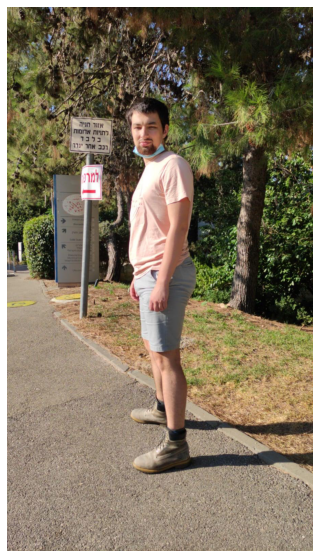

In [14]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1) 
ax.set_axis_off()

imgplot = plt.imshow(image)
plt.show()

In [15]:
padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)

In [16]:
import torch

x = aug(padded_image)
x = torch.unsqueeze(x, 0)

In [17]:
device='cuda:0'
model = model.to(device=device)
x = x.to(device=device)

In [18]:
with torch.no_grad():
    prediction = model(x).squeeze()

In [19]:
mask = (prediction > 0.).cpu().numpy().astype(np.uint8)

In [20]:
mask = unpad(mask, pads)

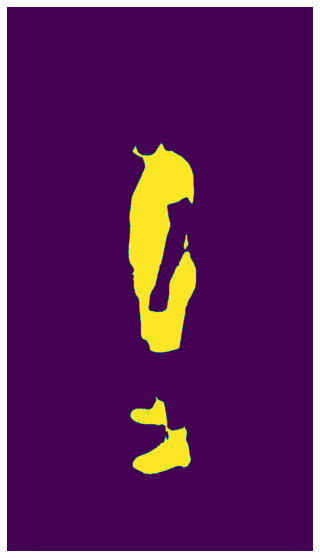

In [21]:
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(1,1,1) 
ax.set_axis_off()

imgplot = plt.imshow(mask)
plt.show()

In [22]:
dst = cv2.addWeighted(image, 1, (cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * (0, 255, 0)).astype(np.uint8), 0.5, 0)

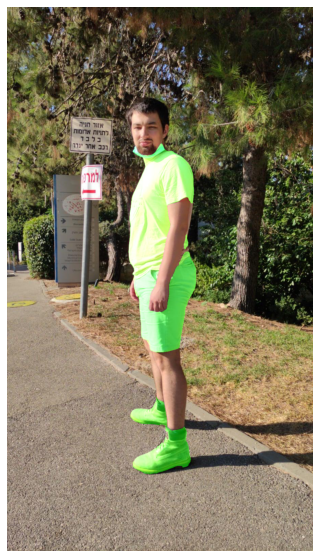

In [23]:
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(1,1,1) 
ax.set_axis_off()

imgplot = plt.imshow(dst)
plt.show()